# Vehicle Classification of Aerial View Imagery from EO and SAR Sensors 
### *Team Members: Justin Jeng, Shirley Zhong, Tiffany Shih*

# Background and Objective

For our project, we chose to perform vehicle classification using aerial view imagery from EO and SAR sensors. The dataset we chose contains labeled images belonging to one of the 10 classes of vehicles: sedan, suv, pickup truck, van, box truck, motorcycle, flatbed truck, bus, pickup truck with tariler, or flatbed truck with trailer. Each scene represented through the aerial images is captured in the visible spectrum through an electro-optical (EO) sensor as well as a synthetic aperture radar (SAR). The SAR images generally contain more noise than the EO images; however, the SAR imagery is beneficial for unclear weather conditions. The link to the dataset is as follows: [Multi-Modal Aerial View Object Classification (MAVOC)](https://codalab.lisn.upsaclay.fr/competitions/1392)

To perform this classification problem, we developed both non-learned and learned features and performed image classification using 4 supervised model classification techniques (2 for the non-learned, 2 for the learned). The non-learned features were based on detecting the size and shapes of the vehicles, as well as HOG and pixel feature engineering/PCA reduction techniques. The learned features were implemented using CNN classification. The CNN features were also extracted and fed into ResNet152 embeddings and an ensemble of KNN and SVM classifiers using auto-sklearn as an additional classification method.

# 1. Data Exploration and Image Pre-Processing (Tiffany)

The image resolution of the EO sensors is 32 x 32, and the image resolution of the SAR images are 56 x 56. 

In [172]:
# Imports
import os, os.path
import csv
import numpy as np
import pandas as pd
import re
import matplotlib
import math
import matplotlib.pyplot as plt
import seaborn as sns
import imageio
from collections import defaultdict
from glob import glob
from utils import *
import cv2
from scipy.ndimage import convolve
from skimage.draw import ellipse
from skimage.measure import label, regionprops, regionprops_table
from skimage.transform import rotate
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from mpl_toolkits.axes_grid1 import make_axes_locatable
from textwrap import wrap
from sklearn.decomposition import PCA
from skimage.feature import hog
from sklearn.manifold import TSNE
from textwrap import wrap
import time


## 1.1. Data Split

First, we read the images from the original file directory structure (each folder represents a class label with both EO and SAR images belonging to that class). We split the dataset into 80/10/10 for training, validation, and test sets across each class and ensure each partition has equal distribution (10% of samples for each of the 10 classes). To ensure balanced class representation, we downsample to the minority class (class 7: flatbed truck). This is a bit more reliable than performing stratified sampling (where there is a high imbalance toward class 0), or upsampling by using a noisy process such as SMOTE.

In [ ]:
rootdir = '../train_images'
img_pairs = defaultdict(lambda: dict)

eo_prefix = "EO" # case sensitive!
sar_prefix = "SAR"
class_folders = os.listdir(rootdir)

# populate a dictionary with image_id number, the eo and sar file path, and class label. ignore hidden files.
for class_dir in class_folders:
    if not class_dir.startswith('.'):
        for file in os.listdir(os.path.join(rootdir, class_dir)):
            if not file.startswith('.'):
                id = int(re.findall("\d+", file)[0]) # grab the integer (image_id) in filename and use as key
                label = int(class_dir)
                img_path = os.path.join(rootdir,class_dir, file)

                if id in img_pairs.keys():
                    if file.startswith(eo_prefix):
                        img_pairs[id].update({"eo_img": img_path})
                    if file.startswith(sar_prefix):
                        img_pairs[id].update({"sar_img": img_path})
                else:
                    if file.startswith(eo_prefix):
                        img_pairs[id] = {"eo_img": img_path, "sar_img":None, "label":label}
                    if file.startswith(sar_prefix):
                        img_pairs[id] = {"eo_img": None,"sar_img": img_path, "label":label}

partition_df = pd.DataFrame.from_dict(img_pairs, orient='index')
partition_df.reset_index(inplace=True)
partition_df = partition_df.rename(columns = {'index':'image_id'})

partition_df["idx"] = partition_df.index
downsample_amount = partition_df["label"].value_counts().min() # 624

classes_to_downsample = list(range(0,10))
classes_to_downsample.pop(7)
minority_class_df = partition_df[partition_df["label"]==7]

appended_data = [minority_class_df]

# generate the new balanced dataframe
for label in classes_to_downsample:
    down_df = partition_df[partition_df["label"]==label]
    down_df = resample(down_df, replace=False, n_samples=downsample_amount, random_state=seed)
    appended_data.append(down_df)

samples_bal_df = pd.concat(appended_data)

print("Downsampled train split class counts")
samples_bal_df["label"].value_counts()

X = samples_bal_df
y = samples_bal_df["label"].tolist()
# 80% training
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=seed)

# 10%/10% dev/test
X_dev, X_test, y_dev, y_test = train_test_split(X_test, y_test, stratify=y_test, test_size=0.5, random_state=seed)
X_train["partition"], X_dev["partition"], X_test["partition"]= "train", "dev", "test"

partition_scheme_df = pd.concat([X_train, X_dev, X_test], axis=0)

print(f"Train samples: {len(X_train.index)}")
print(f"Validation samples: {len(X_dev.index)}")
print(f"Test samples: {len(X_test.index)}")

# partition_scheme_df.to_csv("mavoc_balanced_scheme.csv",index=False) # writing this out

## 1.2. Data Exploration (Tiffany)

In this step, data exploration on the EO and SAR images is performed. First, the files and file-names are set up and stored in pandas dataframes. The images are displayed and checked that EO and SAR are both represented for each scene. The image pixel value histograms (mean, standard deviation, and maximums) and are also evaluated across the classes to check for trends. 

### File Set Up (Required)

In [4]:
# REQUIRED - File name set-up

files = pd.read_csv('mavoc_balanced_scheme.csv')
files['eo_img'] = files['eo_img'].str[9:] # Store all eo image filenames only, removing folder names
files['sar_img'] = files['sar_img'].str[9:] # Store all sar image filenames only, removing folder names
files.head()

image_id         eo_img         sar_img  label partition
0    432192  EO_432192.png  SAR_432192.png      7     train
1     56011   EO_56011.png   SAR_56011.png      2     train
2    172676  EO_172676.png  SAR_172676.png      5     train
3     78915   EO_78915.png   SAR_78915.png      9     train
4     19355   EO_19355.png   SAR_19355.png      2     train

In [7]:
# REQUIRED
# Set up separate training, dev, and test set dataframes
train = files[files['partition'] == 'train']
dev = files[files['partition'] == 'dev']
test = files[files['partition'] == 'test']

In [18]:
# Check that training dataframe was generated correctly
print("Training Dataframe Shape:", train.shape)
train.head()

Training Dataframe Shape: (4992, 5)


image_id         eo_img         sar_img  label partition
0    432192  EO_432192.png  SAR_432192.png      7     train
1     56011   EO_56011.png   SAR_56011.png      2     train
2    172676  EO_172676.png  SAR_172676.png      5     train
3     78915   EO_78915.png   SAR_78915.png      9     train
4     19355   EO_19355.png   SAR_19355.png      2     train

In [19]:
# Check that dev dataframe was generated correctly
print("Dev Dataframe Shape:", dev.shape)
dev.head()

Dev Dataframe Shape: (624, 5)


image_id         eo_img         sar_img  label partition
4992    322104  EO_322104.png  SAR_322104.png      8       dev
4993    258964  EO_258964.png  SAR_258964.png      1       dev
4994     13088   EO_13088.png   SAR_13088.png      4       dev
4995    393877  EO_393877.png  SAR_393877.png      8       dev
4996     20512   EO_20512.png   SAR_20512.png      5       dev

In [20]:
# Check that test dataframe was generated correctly
print("Test Dataframe Shape:", test.shape)
test.head()

Test Dataframe Shape: (624, 5)


image_id         eo_img         sar_img  label partition
5616     20156   EO_20156.png   SAR_20156.png      7      test
5617     56494   EO_56494.png   SAR_56494.png      0      test
5618    203803  EO_203803.png  SAR_203803.png      8      test
5619    294510  EO_294510.png  SAR_294510.png      6      test
5620    155209  EO_155209.png  SAR_155209.png      5      test

In [8]:
# REQUIRED
# Load Vehicle Class Label Names
labels = ['sedan', # 0
          'suv', # 1
          'pickup truck', # 2
          'van', # 3
          'box truck', # 4
          'motorcycle', # 5
          'flatbed truck', # 6
          'bus', # 7
          'pickup truck with trailer', # 8
          'flatbed truck with trailer', # 9
         ]

In [10]:
# REQUIRED
# Set Root Directory Path where images are located
rootdir = '../train_images'

### File Checks (Optional)

In [6]:
# OPTIONAL - Checks that all EO and SAR images are represented in the entire dataset

rootdir = '../train_images' # Directory where all images (train/val/test) are stored. 
total_eo_files = 0
total_sar_files = 0
for file in os.listdir(rootdir):
    d = os.path.join(rootdir, file)
    if os.path.isdir(d):
        # Get number of files corresponding to the label for EO and SAR images
        eo_num_files = len([name for name in os.listdir(d) if os.path.isfile(os.path.join(d, name)) and name.startswith("EO")])
        sar_num_files = len([name for name in os.listdir(d) if os.path.isfile(os.path.join(d, name)) and name.startswith("SAR")])
        
        # Print Number of Files for Each Label and EO/SAR Image. 
        # EO and SAR images should have identical number of files for each label
        print("Directory %s (EO): %d" %(d, eo_num_files))
        print("Directory %s (SAR): %d" %(d, sar_num_files))
        
        total_eo_files += eo_num_files
        total_sar_files += sar_num_files
        
# Print total number of EO and SAR images across all labels
print("Total EO Files:", total_eo_files)
print("Total SAR Files:", total_sar_files)

Directory ../train_images/9 (EO): 633
Directory ../train_images/9 (SAR): 633
Directory ../train_images/0 (EO): 234209
Directory ../train_images/0 (SAR): 234209
Directory ../train_images/7 (EO): 624
Directory ../train_images/7 (SAR): 624
Directory ../train_images/6 (EO): 828
Directory ../train_images/6 (SAR): 828
Directory ../train_images/1 (EO): 28089
Directory ../train_images/1 (SAR): 28089
Directory ../train_images/8 (EO): 840
Directory ../train_images/8 (SAR): 840
Directory ../train_images/4 (EO): 1741
Directory ../train_images/4 (SAR): 1741
Directory ../train_images/3 (EO): 10655
Directory ../train_images/3 (SAR): 10655
Directory ../train_images/2 (EO): 15301
Directory ../train_images/2 (SAR): 15301
Directory ../train_images/5 (EO): 852
Directory ../train_images/5 (SAR): 852
Total EO Files: 293772
Total SAR Files: 293772


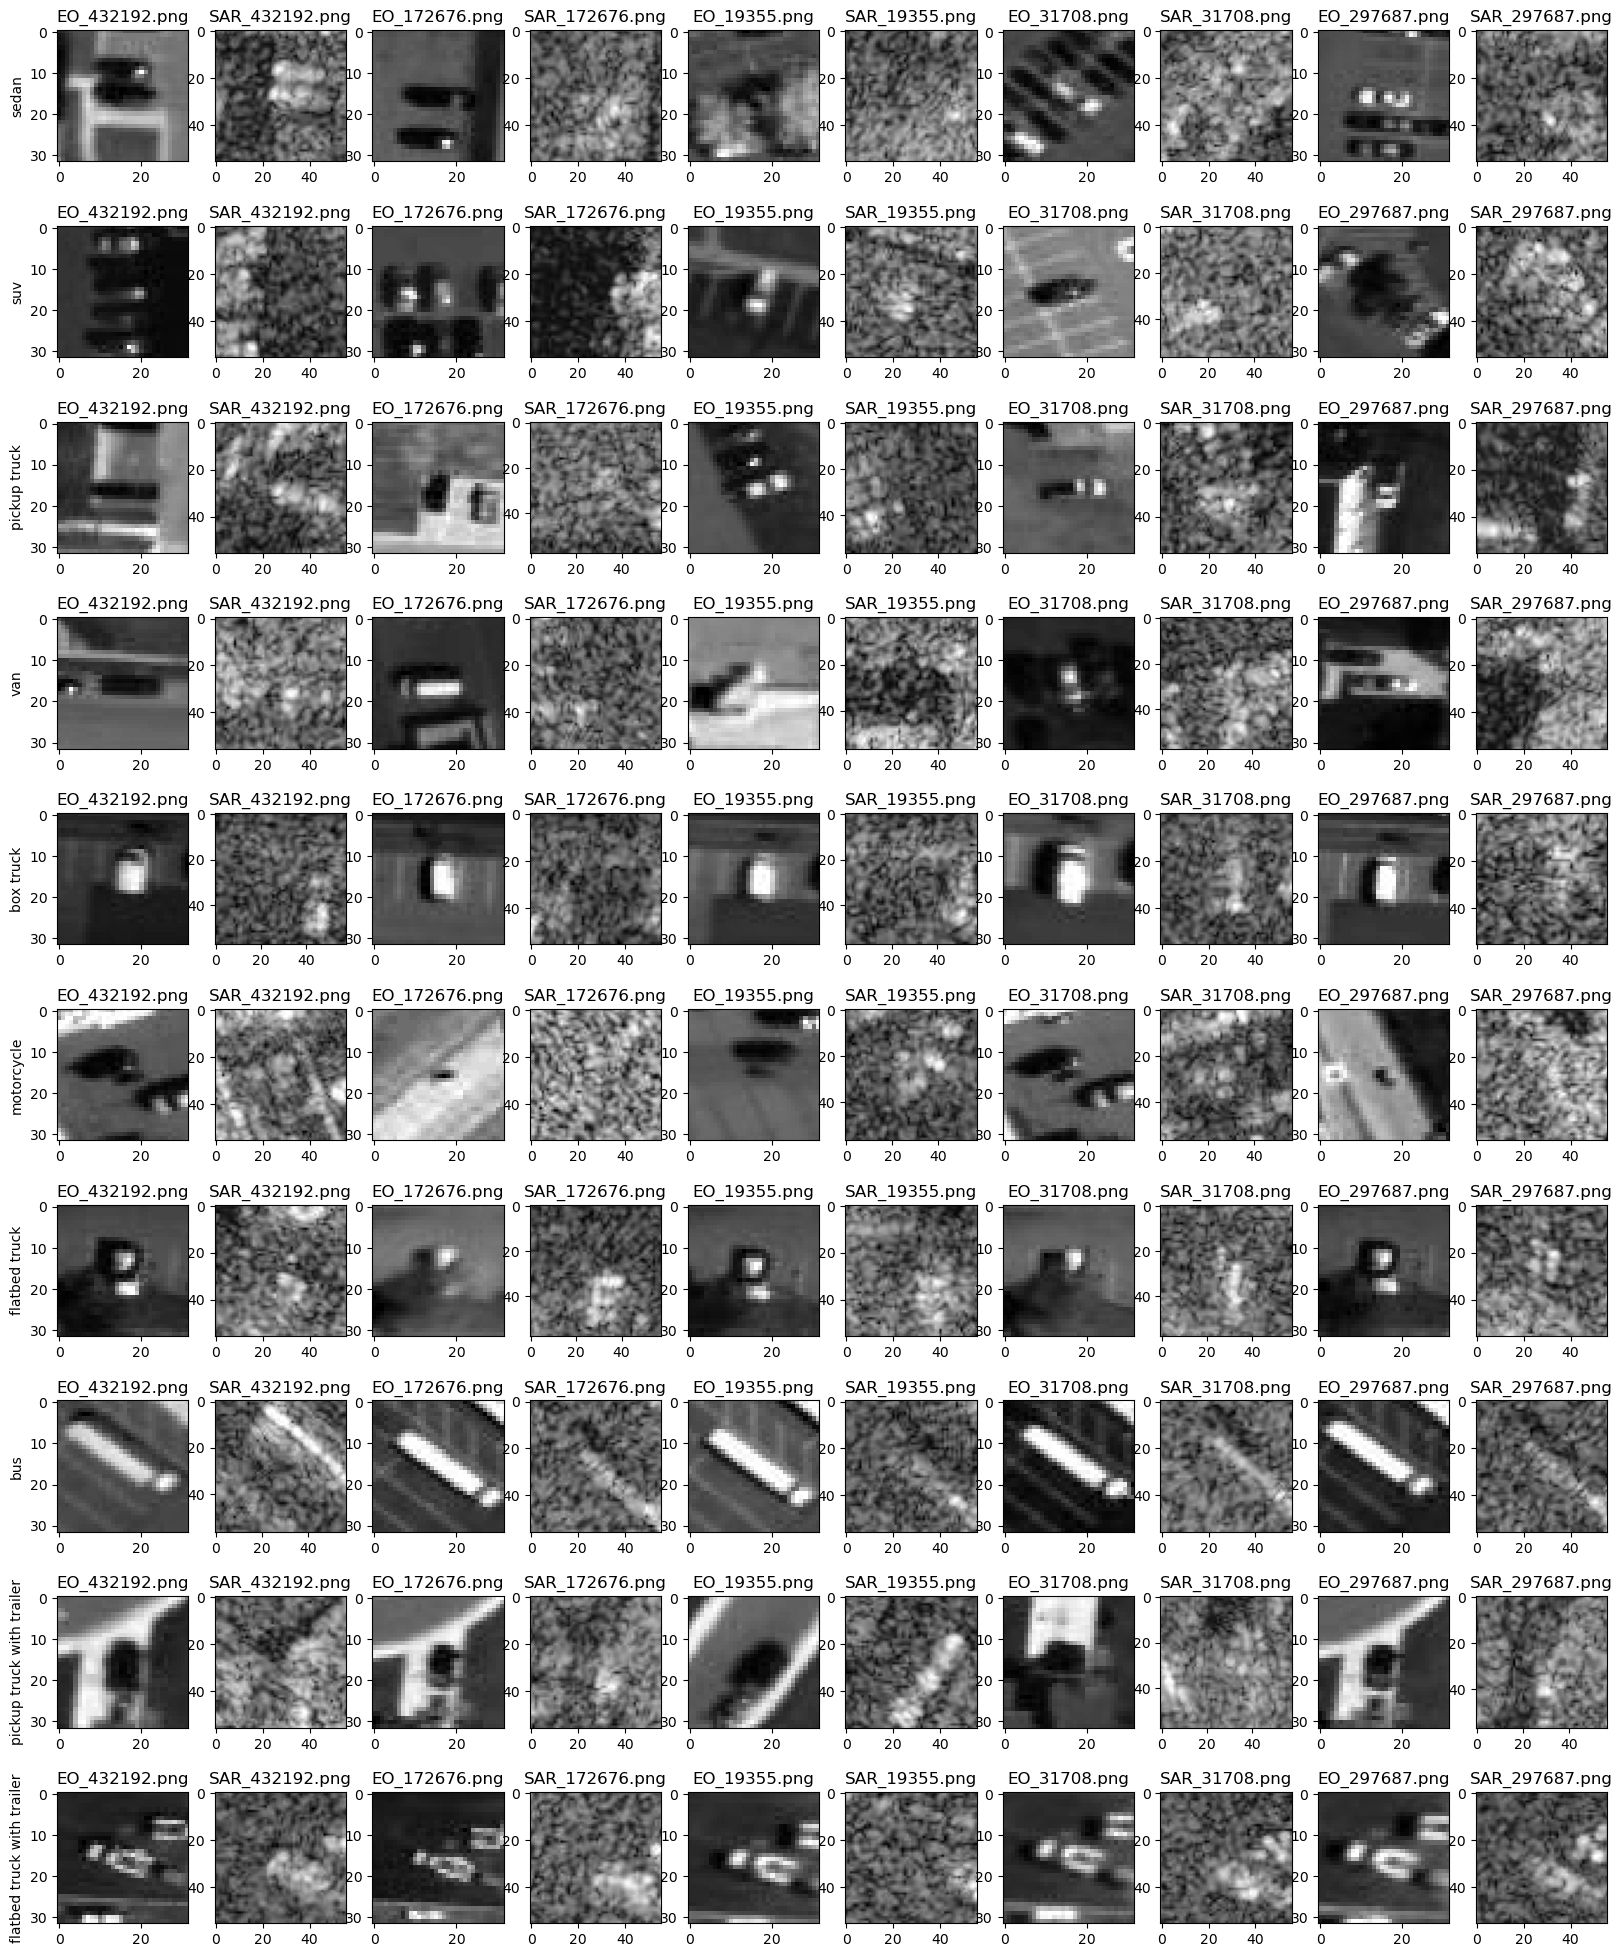

In [11]:
# Open side-by-side the first 5 images for EO and SAR images for all labels in training set
fig, ax = plt.subplots(10, 10, figsize=(20,25))

# For all labels
for i in range(10):
    # For a sample of 5 images
    for j in range(0,10,2):
        # EO path
        path_eo = rootdir + "/" + str(i) + "/" + train[train['label'] == i]['eo_img'].iloc[j]
        # SAR path
        path_sar = rootdir + "/" + str(i) + "/" + train[train['label'] == i]['sar_img'].iloc[j]
        
        # Read images
        img_eo = plt.imread(path_eo)
        img_sar = plt.imread(path_sar)
        
        # Displaying the images
        ax[i][j].imshow(img_eo, cmap='gray')
        ax[i][j].set_title(train['eo_img'].iloc[j])
        ax[i][j+1].imshow(img_sar, cmap='gray')
        ax[i][j+1].set_title(train['sar_img'].iloc[j])
        
    ax[i][0].set_ylabel(labels[i])
    
plt.show()

### Mean, Standard Deviation, and Maximum Image Signal Levels

Image mean, standard deviation, and maximum signal levels for the training images are evaluated to check for any trends across each label. This is particularly to see if low image signals and low standard deviation (which is a measure of contrast) images can be used to detect low quality EO images to replace with SAR images during classification. The result of this was inconclusive - signal level alone cannot be used to determine EO image quality as even low signal level images appear to have distinct edges that can be used to determine vehicle type.

#### Mean

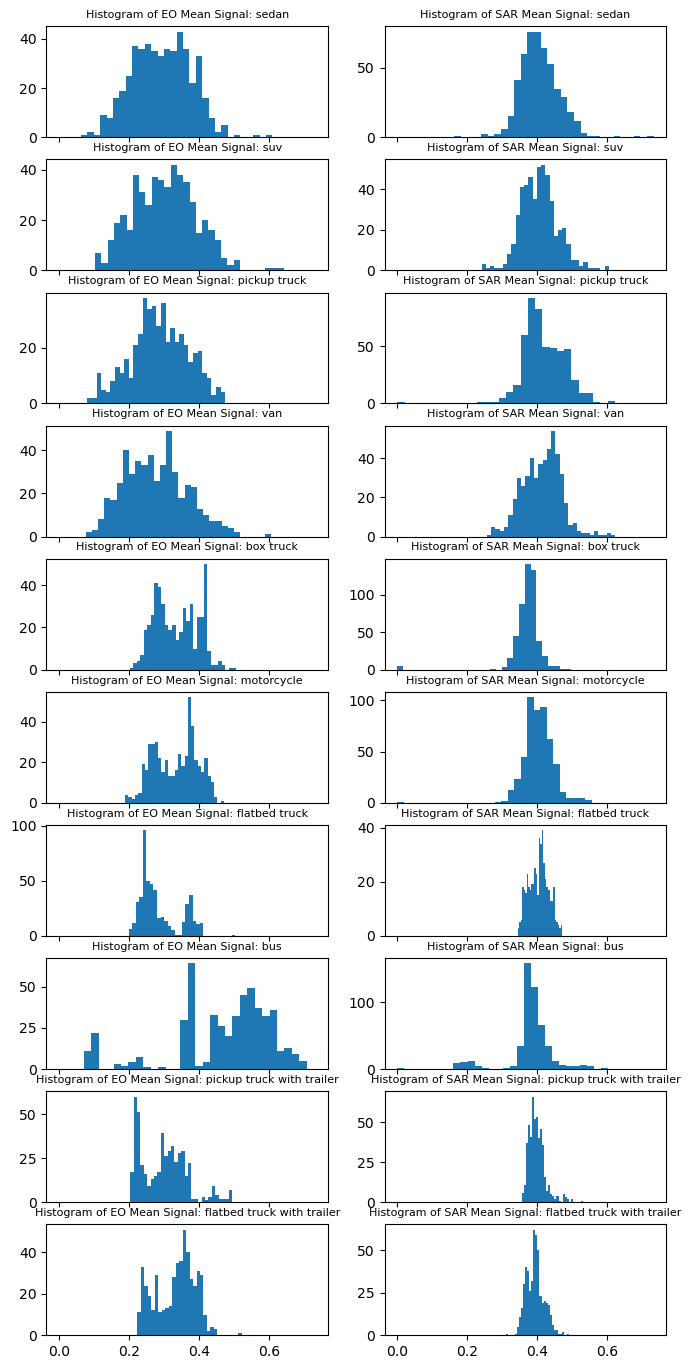

In [88]:
# Compare overall mean signal levels for training images across labels
num_images = train.shape[0]

mean_eo_signals = [[],[],[],[],[],[],[],[],[],[]]
mean_sar_signals = [[],[],[],[],[],[],[],[],[],[]]

for i in range(10): # For all labels
    for index, row in train[train['label'] == i].iterrows(): # Loop through each image corresponding to label i

        # EO path
        path_eo = rootdir + "/" + str(i) + "/" + row['eo_img'] 
        
        # SAR path
        path_sar = rootdir + "/" + str(i) + "/" + row['sar_img'] 
        
        # Read images
        img_eo = plt.imread(path_eo)
        img_sar = plt.imread(path_sar)
        
        # Get mean for the images and append to lists containing all image means
        mean_eo_signals[i].append(np.mean(img_eo))
        mean_sar_signals[i].append(np.mean(img_sar))

# Plot distribution of mean signals for training images across each label
fig, ax = plt.subplots(10, 2, figsize=(8,17), sharex=True)

for i in range(10):
    ax[i][0].hist(mean_eo_signals[i], bins=30)
    ax[i][0].set_title("Histogram of EO Mean Signal: " + labels[i], fontsize=8)
    ax[i][1].hist(mean_sar_signals[i], bins=30)
    ax[i][1].set_title("Histogram of SAR Mean Signal: " + labels[i], fontsize=8)
        
plt.show()

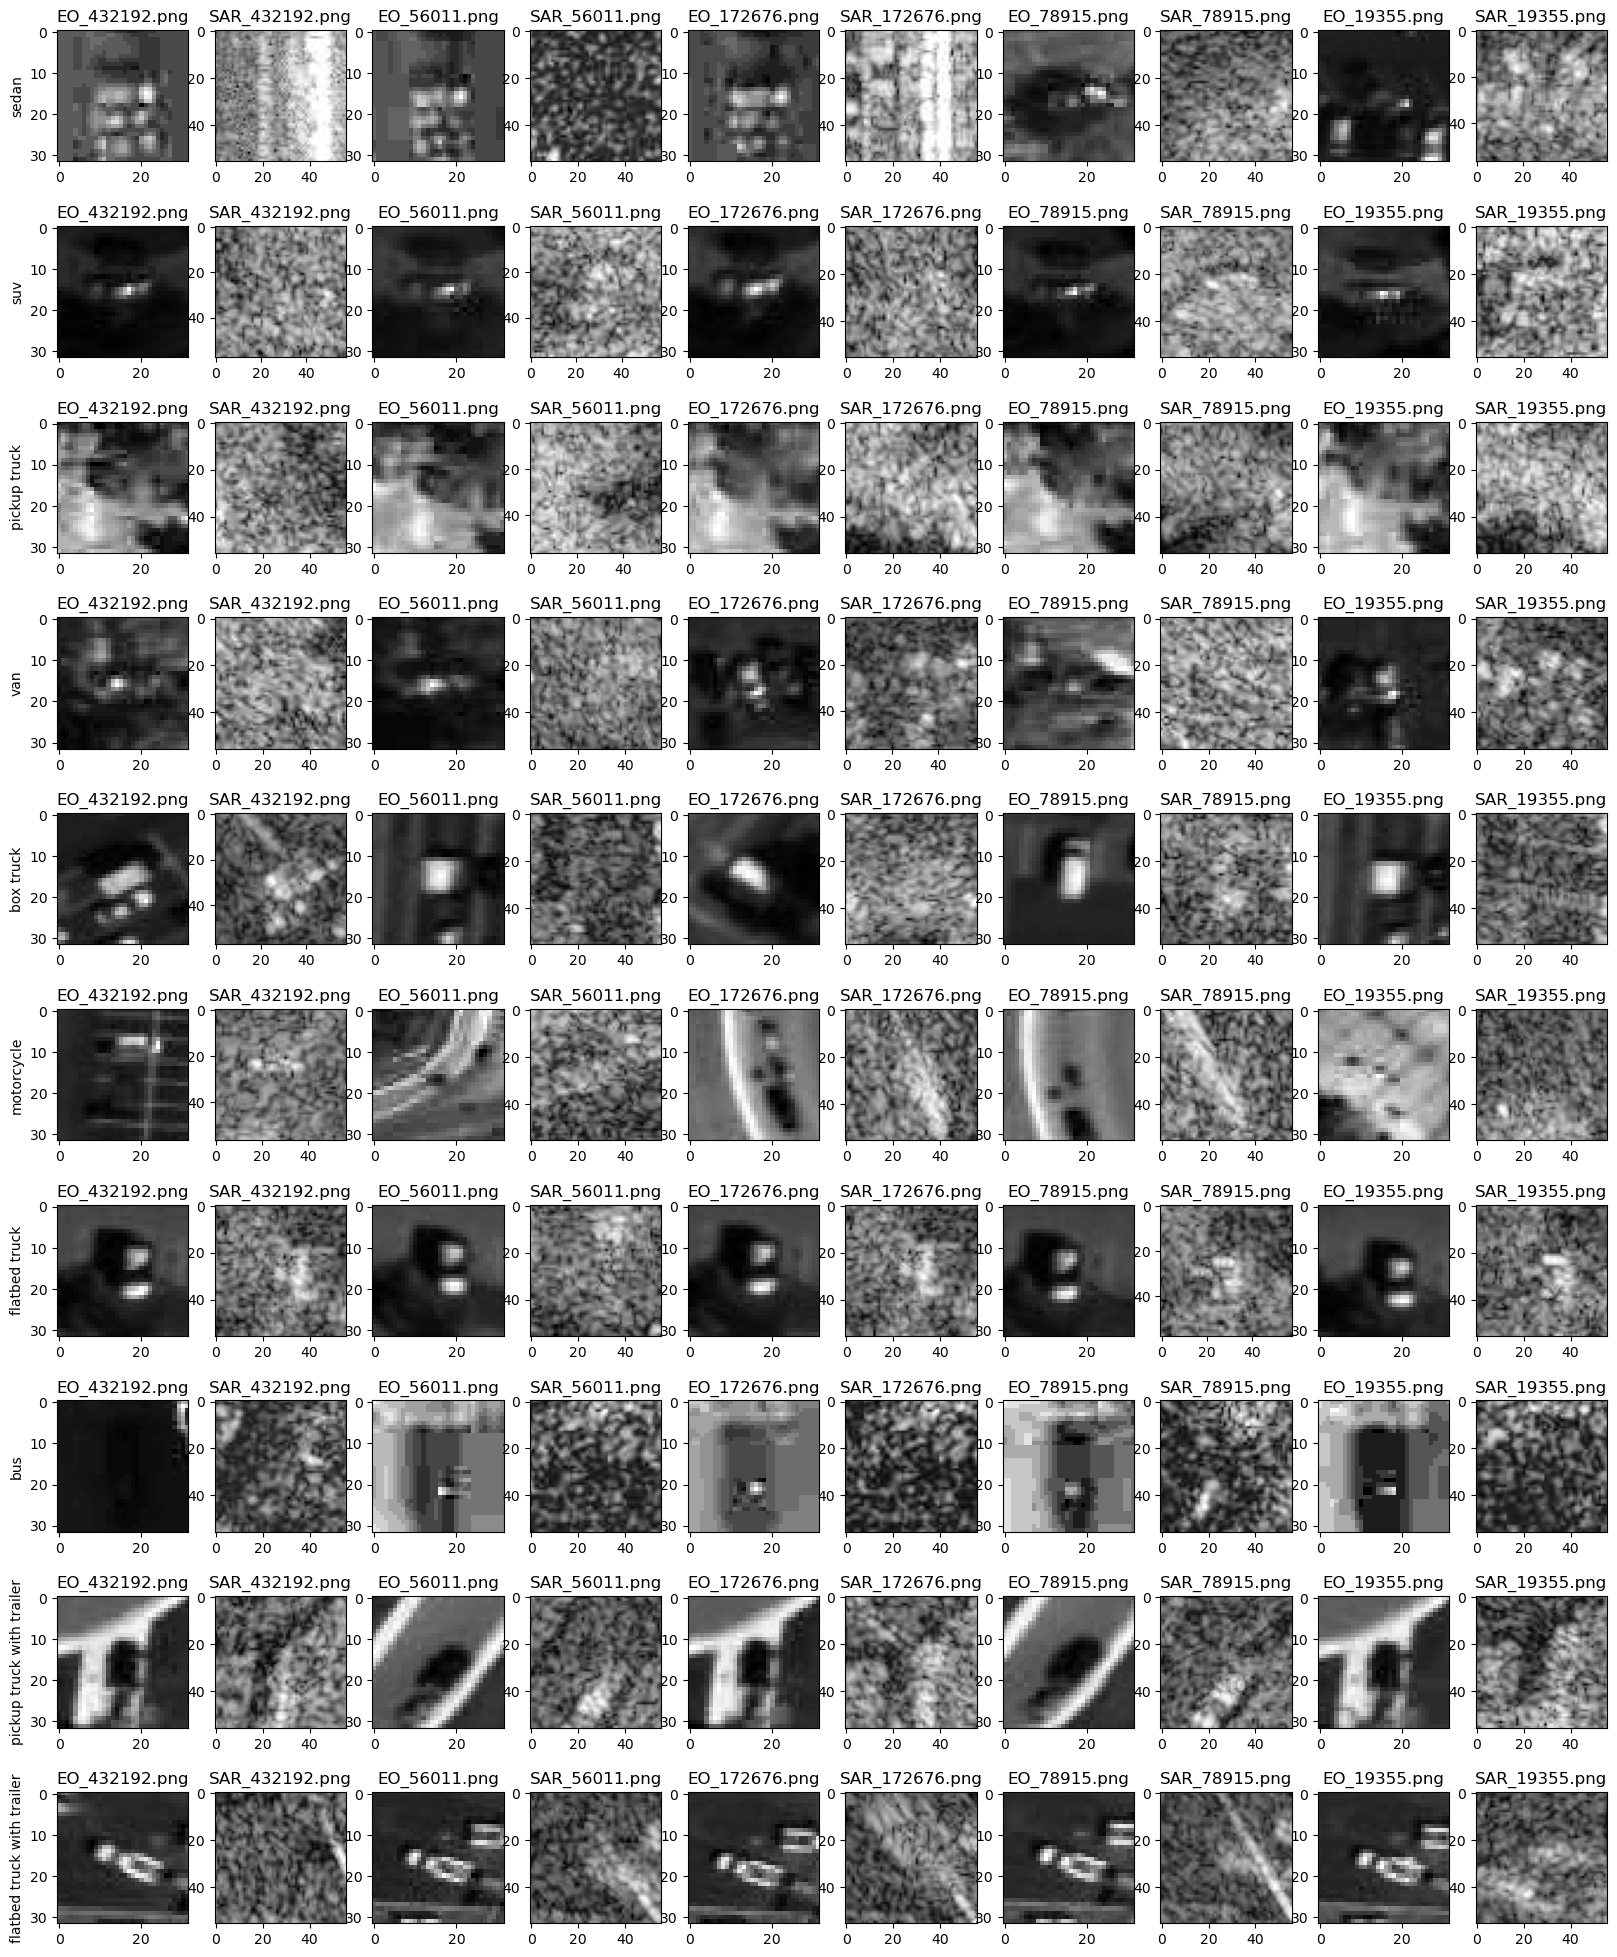

In [90]:
# Plot the lowest mean signal images for num_images number of images

# Get indices of each label in order of lowest mean signal value to greatest
mean_min_ind = []
for i in range(10):
    mean_eo_signals[i] = np.array(mean_eo_signals[i])
    mean_min_ind.append(np.argsort(mean_eo_signals[i]))

# Number of images to plot
num_images = 5

# Plot distribution of mean signals for training images across each label
fig, ax = plt.subplots(10, 2*num_images, figsize=(20,25))

for i in range(10): # For all labels
    
    for j in range(num_images):
        # EO path
        path_eo = rootdir + "/" + str(i) + "/" + train[train['label'] == i]['eo_img'].iloc[mean_min_ind[i][j]]
        
        # SAR path
        path_sar = rootdir + "/" + str(i) + "/" + train[train['label'] == i]['sar_img'].iloc[mean_min_ind[i][j]]
        
        # Read images
        img_eo = plt.imread(path_eo)
        img_sar = plt.imread(path_sar)
        
        # Displaying the image
        ax[i][j*2].imshow(img_eo, cmap='gray')
        ax[i][j*2].set_title(train['eo_img'].loc[j])
        ax[i][j*2+1].imshow(img_sar, cmap='gray')
        ax[i][j*2+1].set_title(train['sar_img'].loc[j])
        
    ax[i][0].set_ylabel(labels[i])
    
plt.show()

#### Standard Deviation

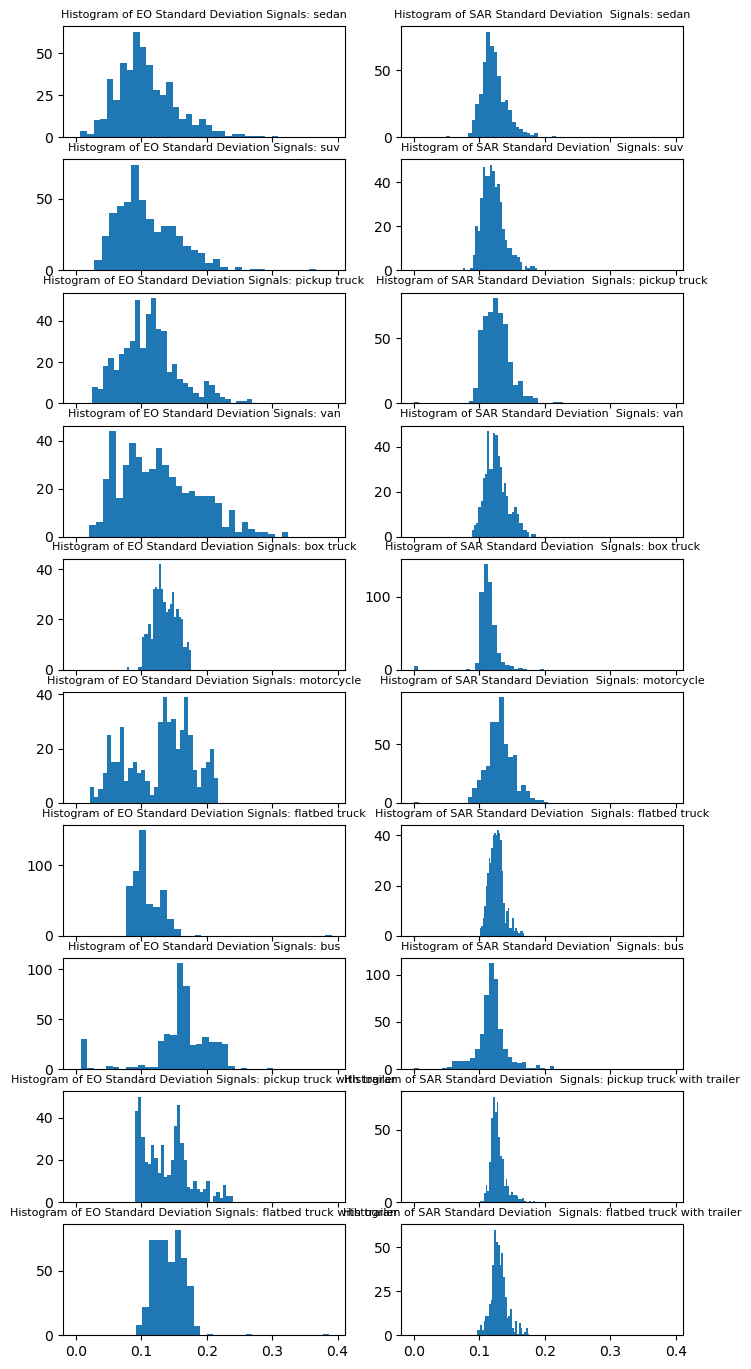

In [89]:
# Compare overall standard deviation levels for training images across labels
num_images = train.shape[0]

std_eo_signals = [[],[],[],[],[],[],[],[],[],[]]
std_sar_signals = [[],[],[],[],[],[],[],[],[],[]]

for i in range(10): # For all labels
    for index, row in train[train['label'] == i].iterrows(): # Loop through each image corresponding to label i

        # EO path
        path_eo = rootdir + "/" + str(i) + "/" + row['eo_img'] 
        
        # SAR path
        path_sar = rootdir + "/" + str(i) + "/" + row['sar_img'] 
        
        # Read images
        img_eo = plt.imread(path_eo)
        img_sar = plt.imread(path_sar)
        
        # Get standard deviations for the images and append to lists containing all image standard deviations
        std_eo_signals[i].append(np.std(img_eo))
        std_sar_signals[i].append(np.std(img_sar))

# Plot distribution of mean signals for training images across each label
fig, ax = plt.subplots(10, 2, figsize=(8,17), sharex=True)

for i in range(10):
    ax[i][0].hist(std_eo_signals[i], bins=30)
    ax[i][0].set_title("Histogram of EO Standard Deviation Signals: " + labels[i], fontsize=8)
    ax[i][1].hist(std_sar_signals[i], bins=30)
    ax[i][1].set_title("Histogram of SAR Standard Deviation  Signals: " + labels[i], fontsize=8)
        
plt.show()

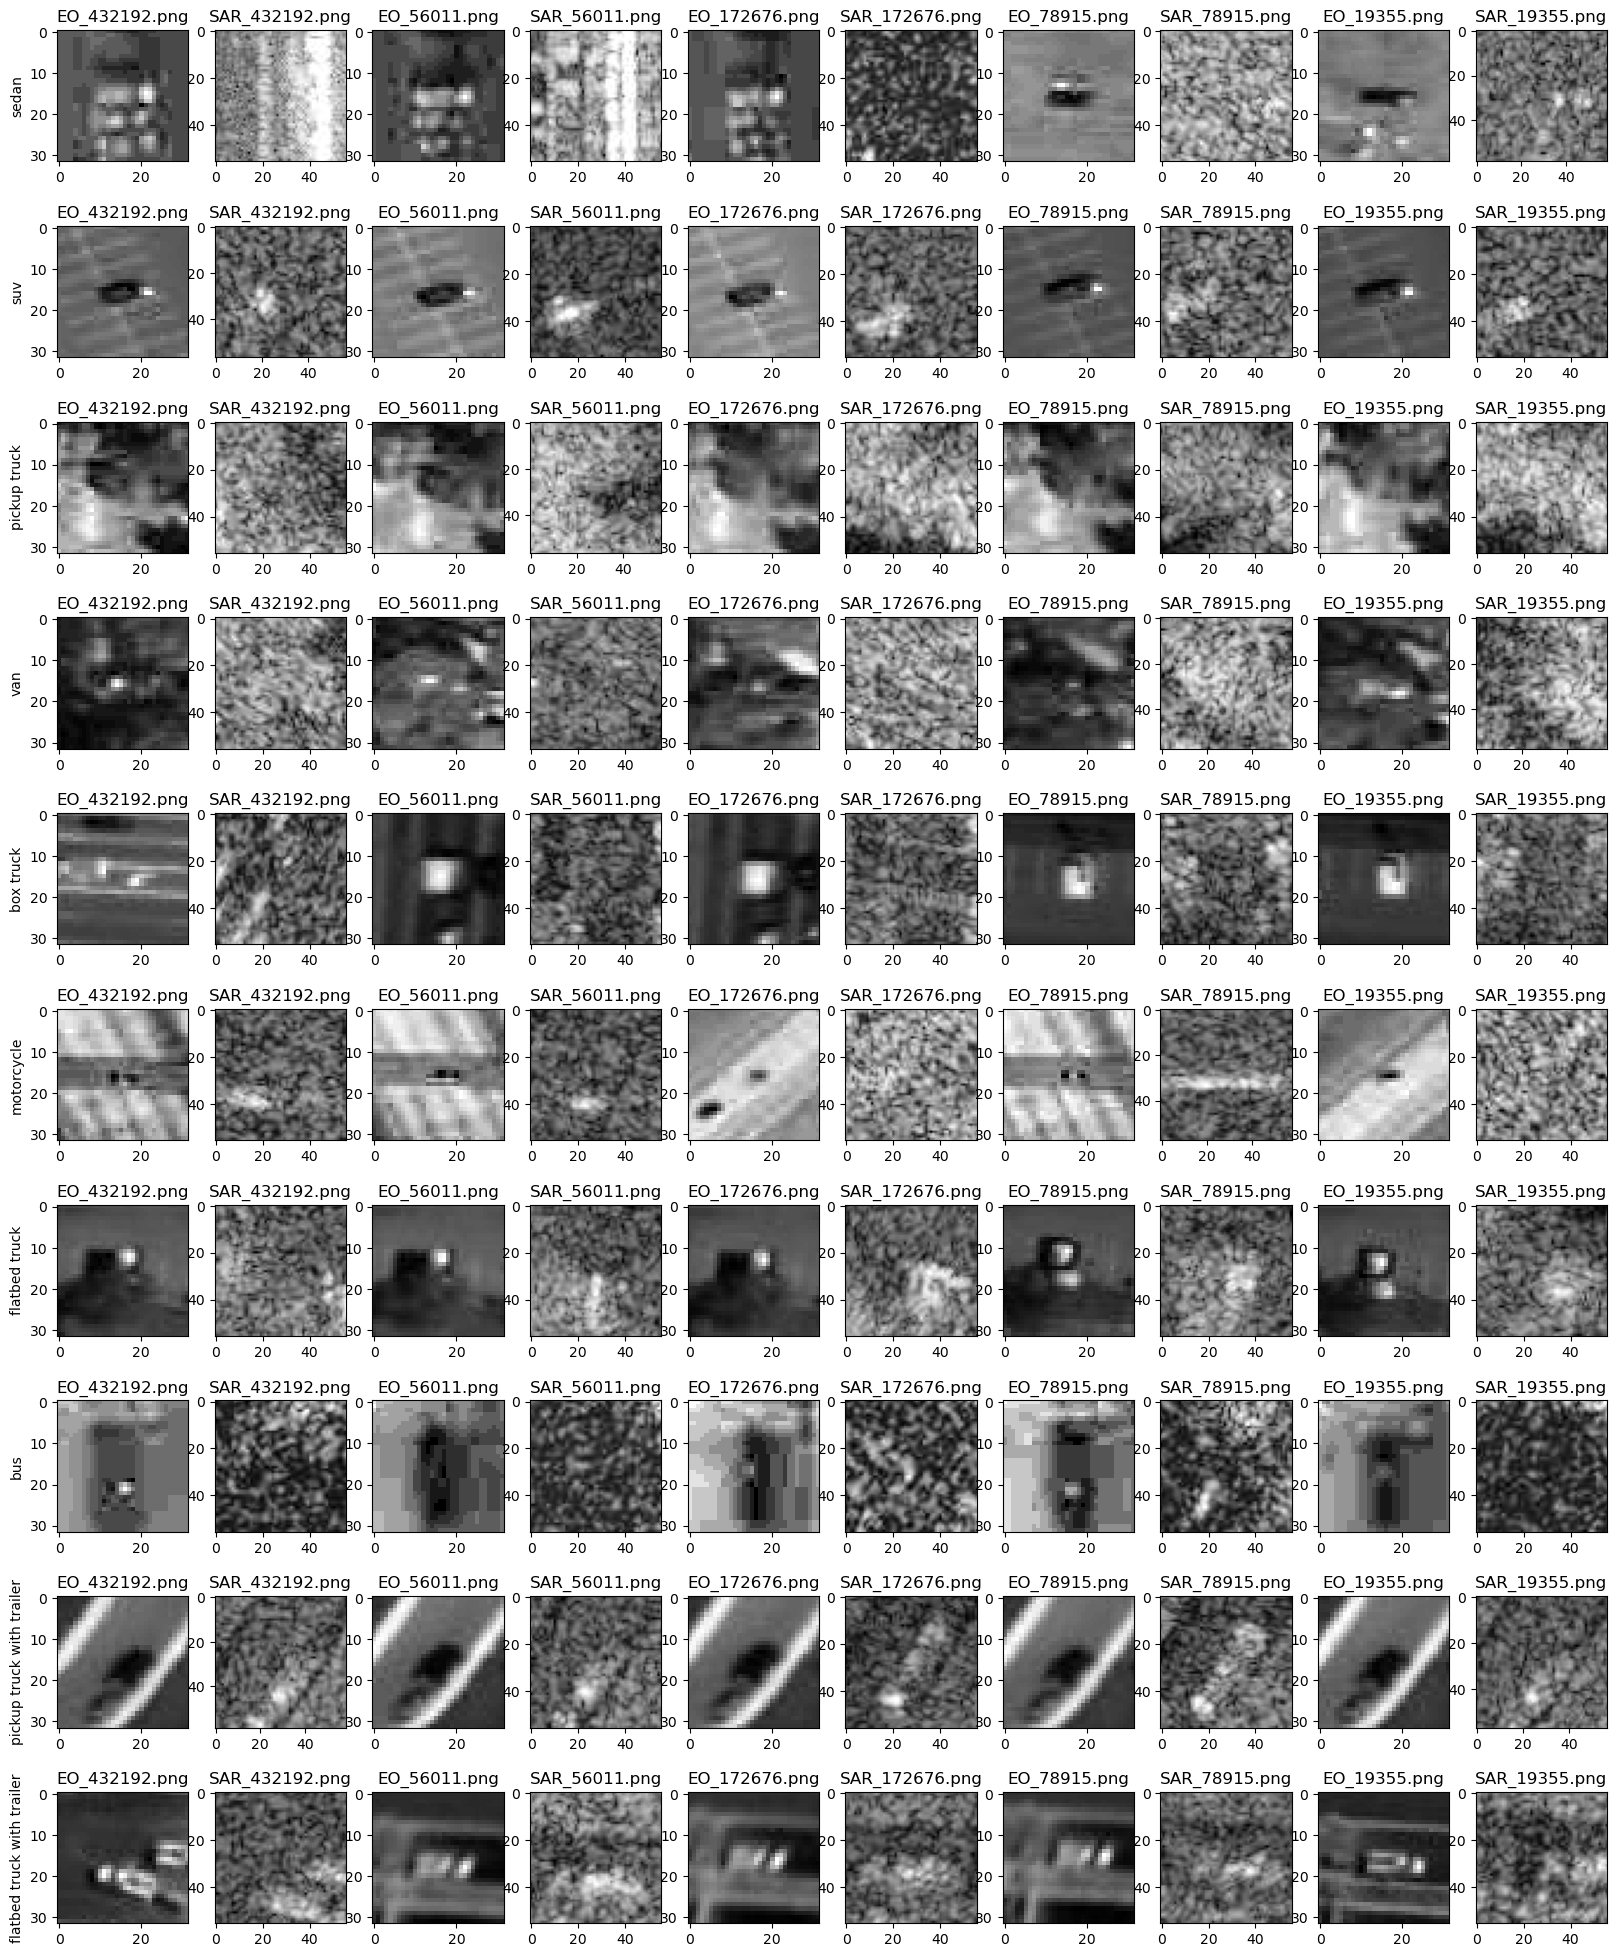

In [91]:
# Plot the lowest standard deviation signal images for num_images number of images

# Get indices of each label in order of lowest standard deviation to greatest
std_min_ind = []
for i in range(10):
    std_eo_signals[i] = np.array(std_eo_signals[i])
    std_min_ind.append(np.argsort(std_eo_signals[i]))

# Number of images to plot
num_images = 5

# Plot distribution of standard deviation signals for training images across each label
fig, ax = plt.subplots(10, 2*num_images, figsize=(20,25))

for i in range(10): # For all labels
    
    for j in range(num_images):
        # EO path
        path_eo = rootdir + "/" + str(i) + "/" + train[train['label'] == i]['eo_img'].iloc[std_min_ind[i][j]]
        
        # SAR path
        path_sar = rootdir + "/" + str(i) + "/" + train[train['label'] == i]['sar_img'].iloc[std_min_ind[i][j]]
        
        # Read images
        img_eo = plt.imread(path_eo)
        img_sar = plt.imread(path_sar)
        
        # Displaying the image
        ax[i][j*2].imshow(img_eo, cmap='gray')
        ax[i][j*2].set_title(train['eo_img'].loc[j])
        ax[i][j*2+1].imshow(img_sar, cmap='gray')
        ax[i][j*2+1].set_title(train['sar_img'].loc[j])
        
    ax[i][0].set_ylabel(labels[i])
    
plt.show()

#### Maximum

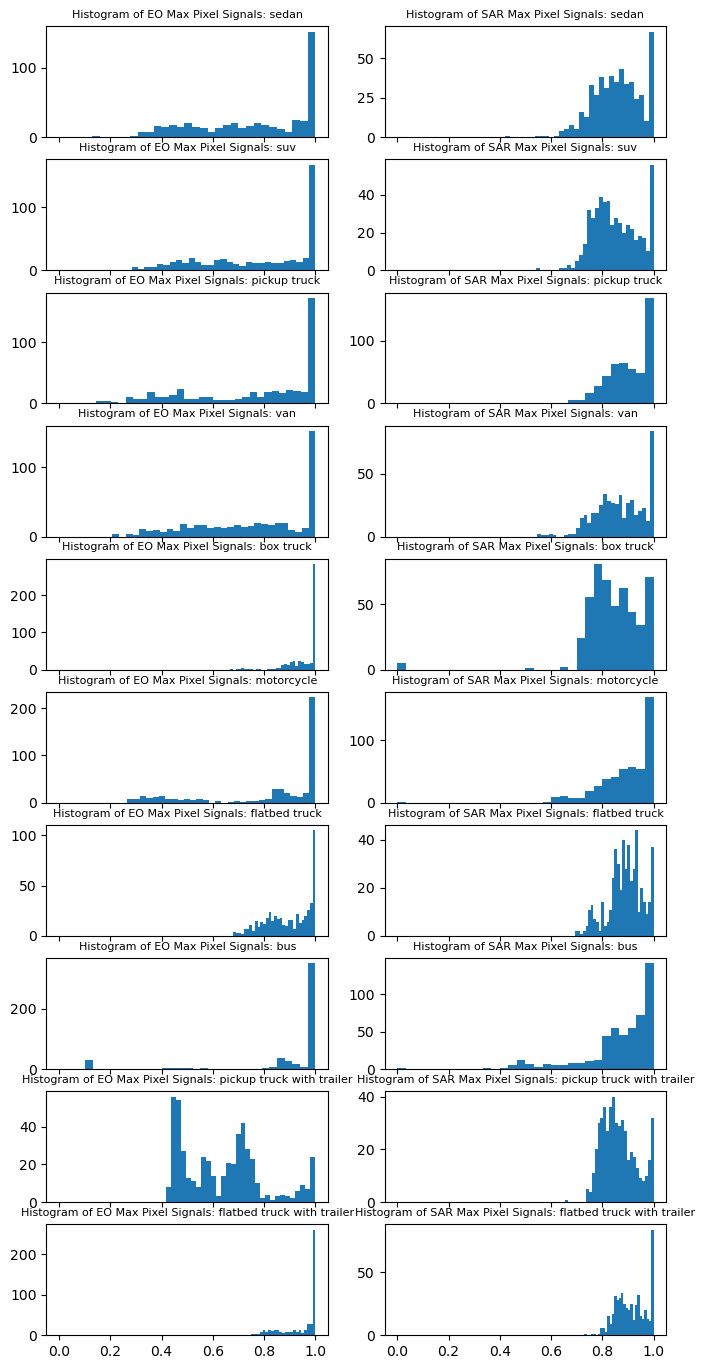

In [92]:
# Compare max pixel values for training images across labels
num_images = train.shape[0]

max_eo_signals = [[],[],[],[],[],[],[],[],[],[]]
max_sar_signals = [[],[],[],[],[],[],[],[],[],[]]

for i in range(10): # For all labels
    for index, row in train[train['label'] == i].iterrows(): # Loop through each image corresponding to label i

        # EO path
        path_eo = rootdir + "/" + str(i) + "/" + row['eo_img'] 
        
        # SAR path
        path_sar = rootdir + "/" + str(i) + "/" + row['sar_img'] 
        
        # Read images
        img_eo = plt.imread(path_eo)
        img_sar = plt.imread(path_sar)
        
        # Get pixel max for the images and append to lists containing all image standard deviations
        max_eo_signals[i].append(np.max(img_eo))
        max_sar_signals[i].append(np.max(img_sar))

# Plot distribution of mean signals for training images across each label
fig, ax = plt.subplots(10, 2, figsize=(8,17), sharex=True)

for i in range(10):
    ax[i][0].hist(max_eo_signals[i], bins=30)
    ax[i][0].set_title("Histogram of EO Max Pixel Signals: " + labels[i], fontsize=8)
    ax[i][1].hist(max_sar_signals[i], bins=30)
    ax[i][1].set_title("Histogram of SAR Max Pixel Signals: " + labels[i], fontsize=8)
        
plt.show()

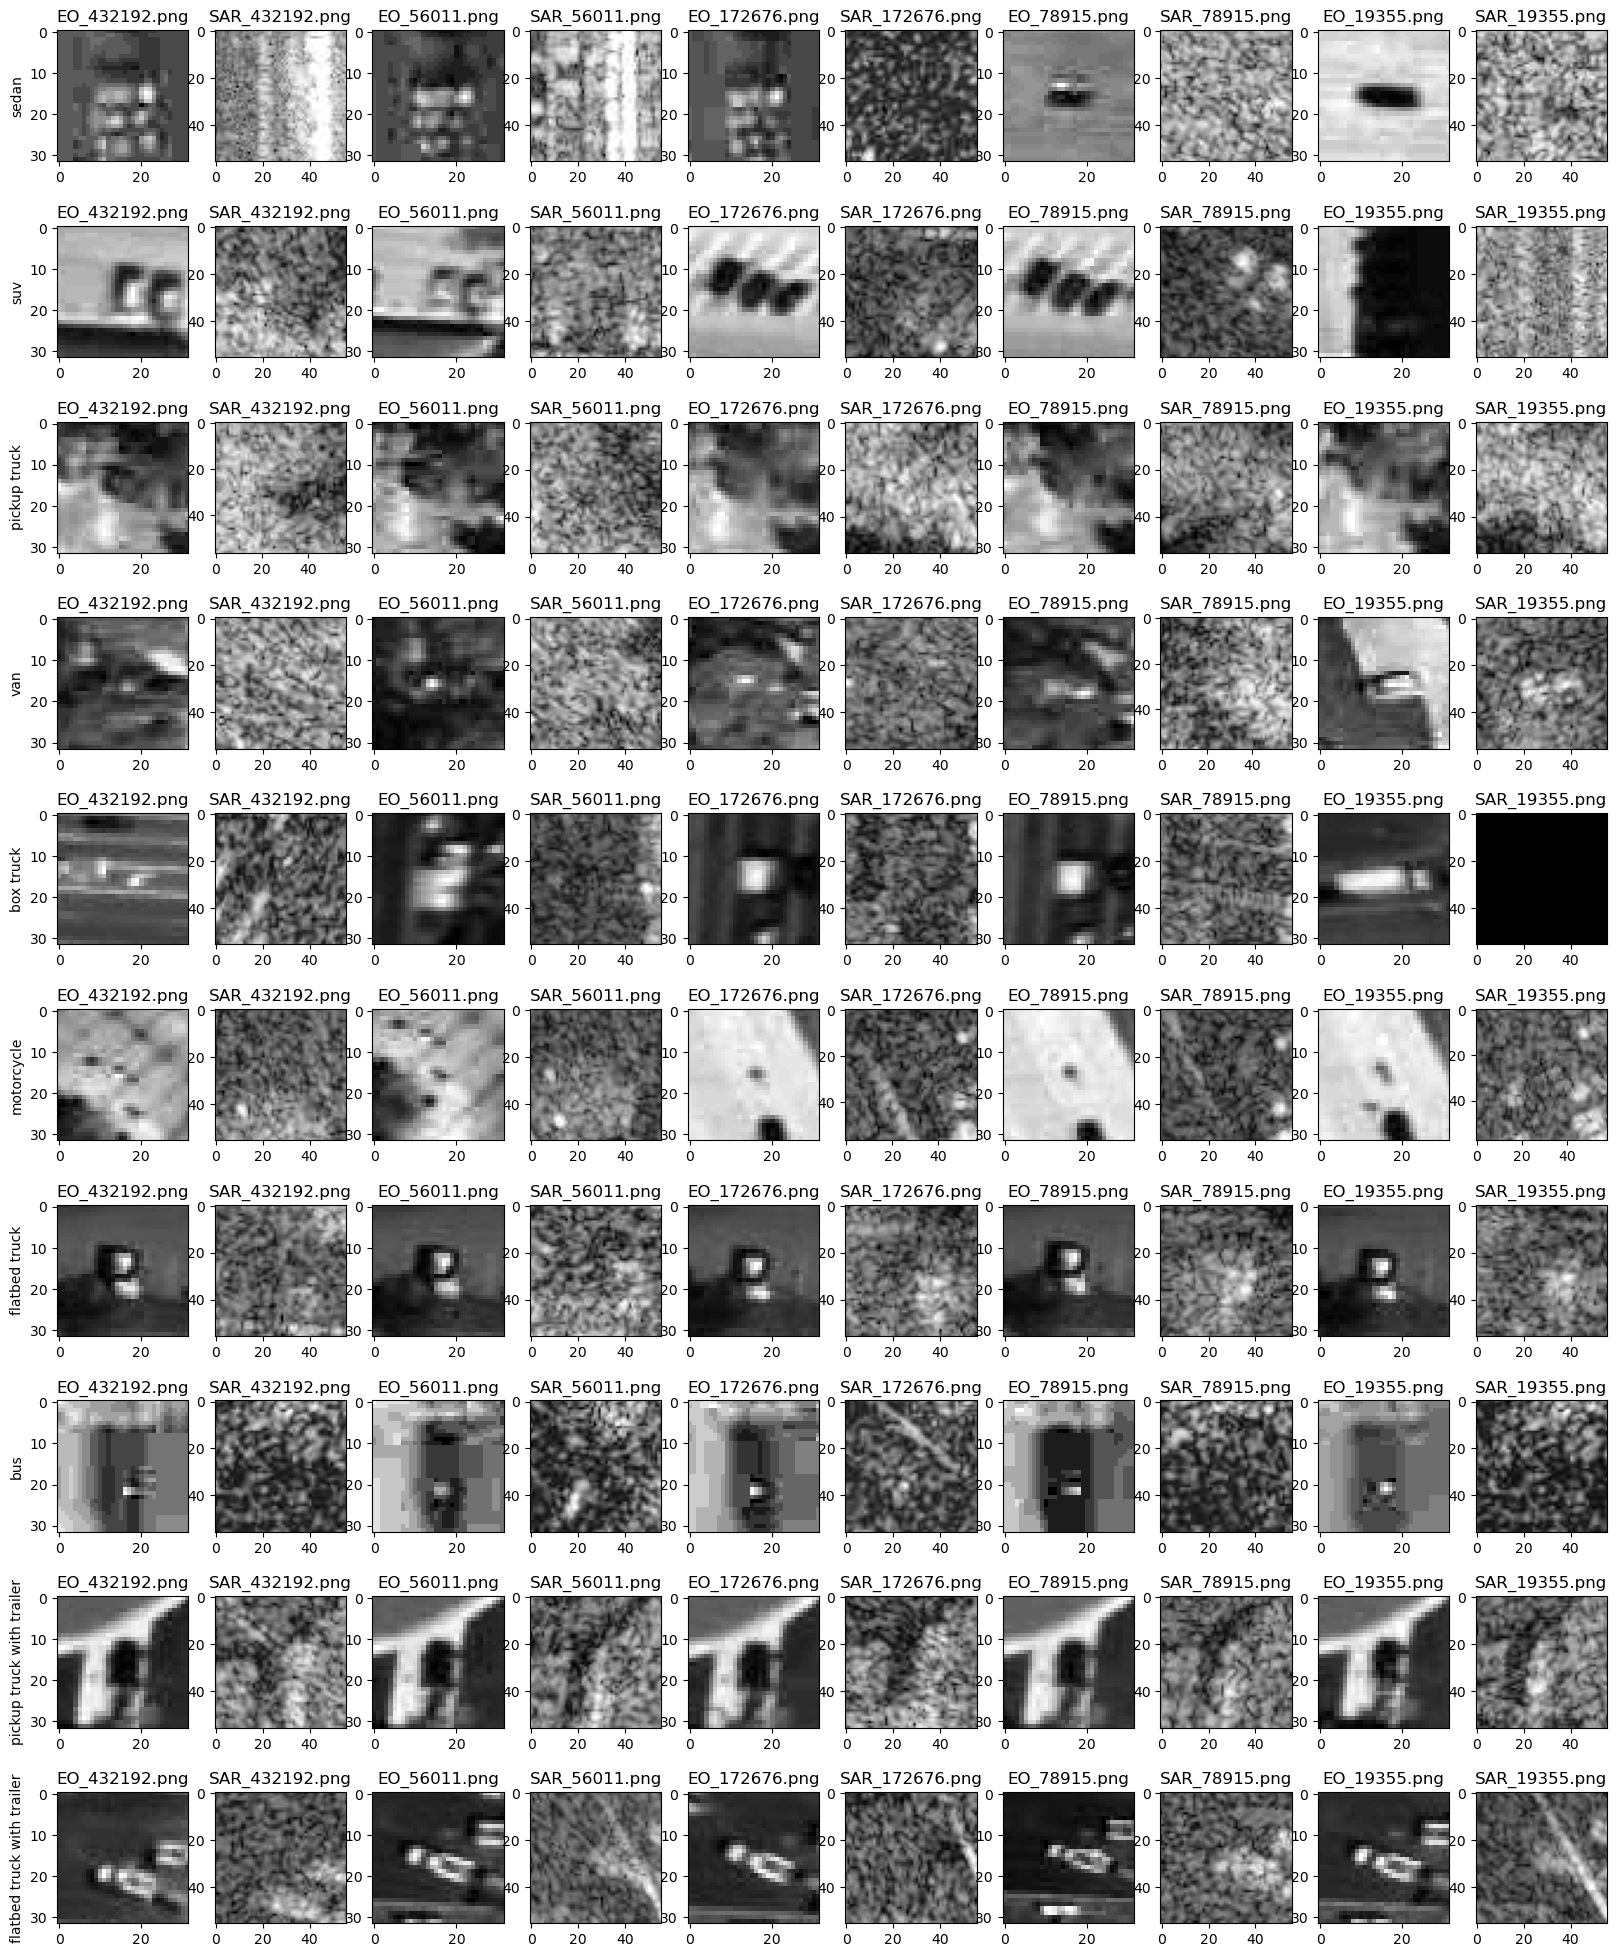

In [93]:
# Plot the lowest max pixel value images for num_images number of images

# Get indices of each label in order of lowest max pixel value to greatest
max_min_ind = []
for i in range(10):
    max_eo_signals[i] = np.array(max_eo_signals[i])
    max_min_ind.append(np.argsort(max_eo_signals[i]))

# Number of images to plot
num_images = 5

# Plot distribution of standard deviation signals for training images across each label
fig, ax = plt.subplots(10, 2*num_images, figsize=(20,25))

for i in range(10): # For all labels
    
    for j in range(num_images):
        # EO path
        path_eo = rootdir + "/" + str(i) + "/" + train[train['label'] == i]['eo_img'].iloc[max_min_ind[i][j]]
        
        # SAR path
        path_sar = rootdir + "/" + str(i) + "/" + train[train['label'] == i]['sar_img'].iloc[max_min_ind[i][j]]
        
        # Read images
        img_eo = plt.imread(path_eo)
        img_sar = plt.imread(path_sar)
        
        # Displaying the image
        ax[i][j*2].imshow(img_eo, cmap='gray')
        ax[i][j*2].set_title(train['eo_img'].loc[j])
        ax[i][j*2+1].imshow(img_sar, cmap='gray')
        ax[i][j*2+1].set_title(train['sar_img'].loc[j])
        
    ax[i][0].set_ylabel(labels[i])
    
plt.show()

# 2. Non-Learned Feature Vector Design & Classification (Tiffany and Shirley)


## 2.1. Feature Engineering: Edge and Shape Detection & Classification (Tiffany)

Through visual inspection of the images across labels, it was found that distinguishing features across the vehicle class labels include vehicle size, shape, and dimensions. As a result, for the non-learned feature engineering section, we opted to perform edge detection and centroid identification of the EO images only to classify the images. 

For the edge enhancement and detection step, we compared two techniques to filter the image (Sobel vs. Gaussian filter): Sobel filtering followed by Canny Edge, compared with a simple Gaussian blur filter followed by Canny Edge.  

We then performed feature extraction by taking the output image of the Canny Edge Detector and feeding it through the scikit-image measure region properties algorithms which will detect centroids (ellipses) and provide properties of the centroids including area, perimeter, major and minor axis dimensions, and center of the centroid's location on the image. For images without any centroids detected, we opted not to remove them and instead set the default centroid dimensions as the diagonals of the full EO image and area as the full 32x32 pixel area. This way, the accuracy is not artificially enhanced by removing images where edges are detected. For images with multiple centroids detected, we assessed the approximate ranges of the properties that belong to the vehicle labeled classes and filtered the centroids for those dimensions only. We then took the centroid with the largest area and designated those centroid's features for that particular image. That way, each image will contain one corresponding centroid area, perimeter, major axis, and minor axis.

Finally, we performed supervised learning on the images by using the extracted features area, perimeter, major axis, and minor axis of the designated centroid for each image from the prior step. 


In [101]:
# OPTIONAL: Tuning Parameters For Comparison of Filtering Techniques 

blur_kernel = (3,3) # Gaussian blur kernel
k_sobel = 3 # k-size for Sobel Edge Detection

thresh_low = 0 # Canny Edge Detection Lower Threshold
thresh_upper = 100 # Canny Edge Detection Upper Threshold

# Centroid parameters to filter only for the smaller vehicles (i.e. everything but the bus)
area_smax = 60 # Max area 
area_smin = 10 # Min area 
axis_ratio_sm = 3.5 # Max major to minor axis ratio 

# Centroid parameters to filter only for the smaller vehicles (i.e. bus)
area_lmax = 200 # Max area 
area_lmin = 60 # Min area 
axis_ratio_lg_min = 3  # Min major to minor axis ratio 
axis_ratio_lg_max = 6  # Max major to minor axis ratio 


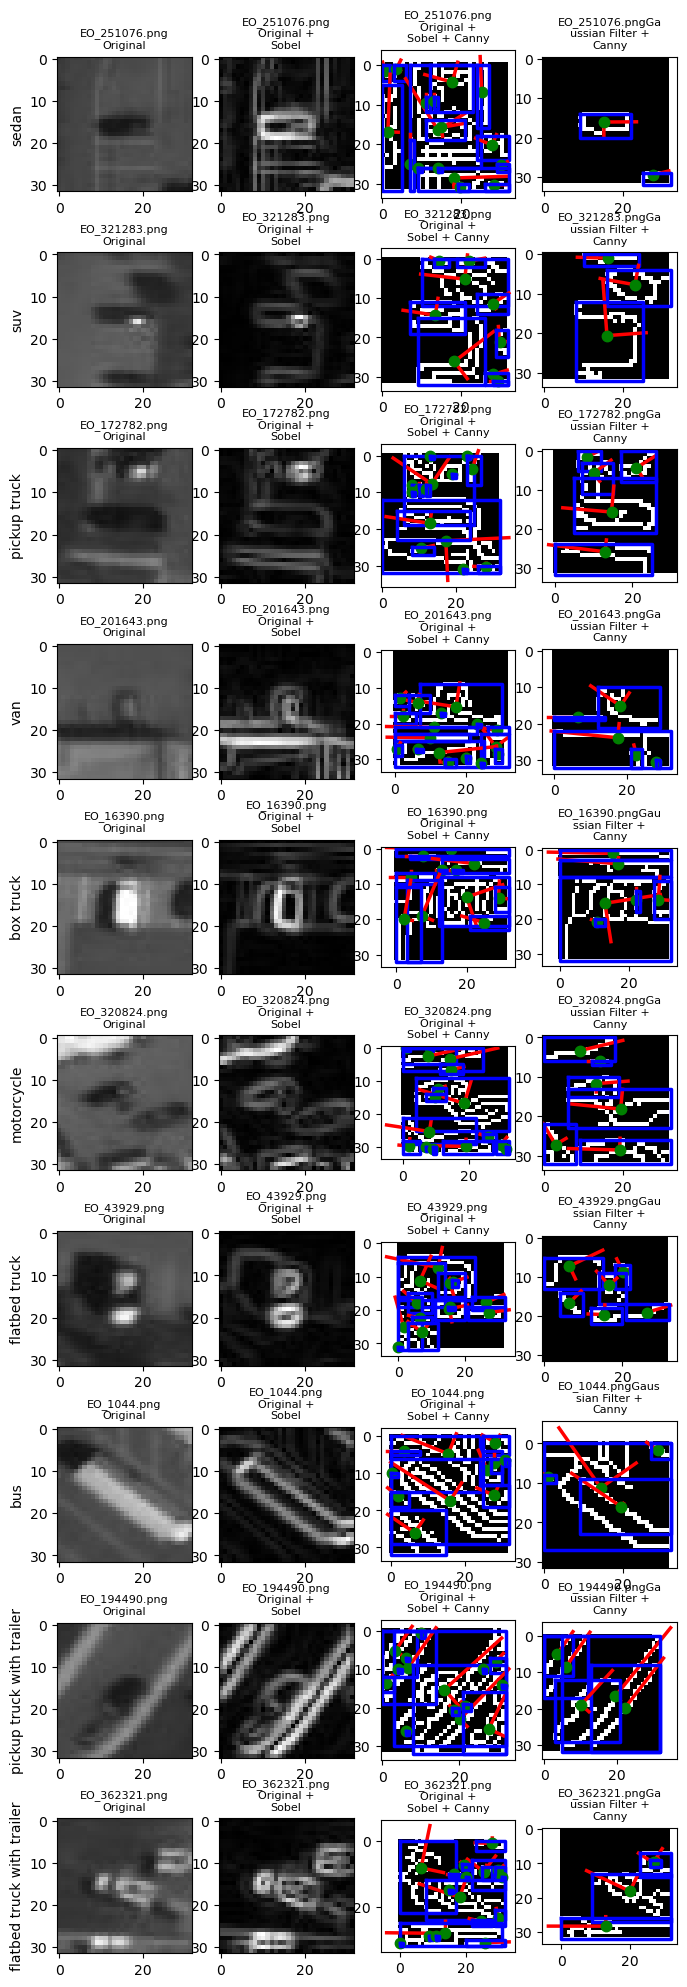

In [114]:
# OPTIONAL: Compare Sobel and Canny Edge Techniques, plot results of edge extraction for both techniques

# Initialize eo image filenames list to label plots
eo_im_filenames = []

fig, ax = plt.subplots(10, 4, figsize = (8, 25))
for i in range(10): # Folder or Label Number
    j = 30 # Image Number (randomnly chosen - can change to a loop if want to include more images)

    # Get path to images - Loop through each label
    filename = train[train['label'] == i]['eo_img'].iloc[j]
    eo_im_filenames.append(train[train['label'] == i]['eo_img'].iloc[j])
    path_eo = rootdir + "/" + str(i) + "/" + train[train['label'] == i]['eo_img'].iloc[j]
    # print(eo_filenames[i][j])


    # Read images
    img_eo = cv2.imread(path_eo)
    
    # Convert to graycsale
    img_gray = cv2.cvtColor(img_eo, cv2.COLOR_BGR2GRAY)
    
    # Method 1: Sobel + Canny Edge
    # TODO: decide the ksize for extracting the edges
    eo_sobelx = cv2.Sobel(img_eo,cv2.CV_32F,1,0, ksize=k_sobel) # Find x and y gradients
    eo_sobely = cv2.Sobel(img_eo,cv2.CV_32F,0,1, ksize=k_sobel)
    eo_magnitude = np.sqrt(eo_sobelx**2.0 + eo_sobely**2.0)
    eo_magnitude = eo_magnitude/np.max(eo_magnitude) # normalize
    
    # Compute EO thresholds
    eo_im_threshold = cv2.Canny(image=(eo_magnitude*255).astype(np.uint8), threshold1=thresh_low, threshold2=thresh_upper) # Canny Edge 
    eo_im_threshold = eo_im_threshold / np.max(eo_im_threshold) # normalize
    
    # Method 2: Gaussian Filter + Canny Edge
    # Blur the image for better edge detection
    img_blur = cv2.GaussianBlur(img_gray, blur_kernel, 0)
    edges = cv2.Canny(image=img_blur, threshold1=thresh_low, threshold2=thresh_upper) # Canny Edge Detection

    # Plot EO
    ax[i][0].imshow(img_eo, cmap='gray')
    ax[i][0].set_title('\n'.join(wrap(eo_im_filenames[i] + " Original",15)), fontsize=8)
    ax[i][1].imshow(eo_magnitude, cmap='gray')
    ax[i][1].set_title('\n'.join(wrap(eo_im_filenames[i] + " Original + Sobel",15)), fontsize=8)
    ax[i][2].imshow(eo_im_threshold, cmap='gray')
    ax[i][2].set_title('\n'.join(wrap(eo_im_filenames[i] + " Original + Sobel + Canny",15)), fontsize=8)
    # im0 = ax[i][2].imshow(eo_im_threshold, cmap='gray')
    # divider = make_axes_locatable(ax[i][2])
    # cax = divider.append_axes("right", size="5%", pad=0.05)
    # plt.colorbar(im0, ax = ax[i][2], cax=cax)
    
    # Get shapes 
    # https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_regionprops.html
    label_img_sobel = label(eo_im_threshold)
    regions_sobel = regionprops(label_img_sobel)
    
    # Plot centroids detected on image
    for props in regions_sobel:
        y0, x0 = props.centroid
        orientation = props.orientation
        x1 = x0 + math.cos(orientation) * 0.5 * props.axis_minor_length
        y1 = y0 - math.sin(orientation) * 0.5 * props.axis_minor_length
        x2 = x0 - math.sin(orientation) * 0.5 * props.axis_major_length
        y2 = y0 - math.cos(orientation) * 0.5 * props.axis_major_length

        # Plotting Only
        ax[i][2].plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
        ax[i][2].plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
        ax[i][2].plot(x0, y0, '.g', markersize=15)

        minr, minc, maxr, maxc = props.bbox
        bx = (minc, maxc, maxc, minc, minc)
        by = (minr, minr, maxr, maxr, minr)
        ax[i][2].plot(bx, by, '-b', linewidth=2.5)
        
    ax[i][3].imshow(edges, cmap=plt.cm.gray)
    ax[i][3].set_title('\n'.join(wrap(eo_im_filenames[i] + "Gaussian Filter + Canny",15)), fontsize=8)
    
    # Get shapes
    # https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_regionprops.html
    label_img_canny = label(edges)
    regions_canny = regionprops(label_img_canny)
    
    # Plot centroids detected on image
    for props in regions_canny:
        y0, x0 = props.centroid
        orientation = props.orientation
        x1 = x0 + math.cos(orientation) * 0.5 * props.axis_minor_length
        y1 = y0 - math.sin(orientation) * 0.5 * props.axis_minor_length
        x2 = x0 - math.sin(orientation) * 0.5 * props.axis_major_length
        y2 = y0 - math.cos(orientation) * 0.5 * props.axis_major_length

        # Plotting Only
        ax[i][3].plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
        ax[i][3].plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
        ax[i][3].plot(x0, y0, '.g', markersize=15)

        minr, minc, maxr, maxc = props.bbox
        bx = (minc, maxc, maxc, minc, minc)
        by = (minr, minr, maxr, maxr, minr)
        ax[i][3].plot(bx, by, '-b', linewidth=2.5)

    # Plotting Only: Set label name for each row
    ax[i][0].set_ylabel(labels[i])
    
    
plt.show()

Based on the results seen above, we decided to use Gaussian Filter + Canny Edge as the Sobel filter resulted in more false positives (centroids detected where there aren't).

### 2.1.1. k-NN Classification Using Feature Engineered Shapes  (Tiffany)

In [124]:
# REQUIRED - Tuning parameters
# These parameters are initially set using training set, tuned using the dev set, then finalized 
# for the test set for final evaluation metrics.

blur_kernel = (3,3) # Gaussian blur
k_sobel = 3 # k-size for Sobel Edge Detection

thresh_low = 0 # Canny Edge Detection Lower Threshold
thresh_upper = 100 # Canny Edge Detection Upper Threshold

area_smax = 60 # Max area for small vehicles
area_smin = 10 # Min area ratio for small vehicles
axis_ratio_sm = 3.5 # Max axis ratio for small vehicles

area_lmax = 200
area_lmin = 60
axis_ratio_lg_min = 3
axis_ratio_lg_max = 6


In [115]:
# REQUIRED - Set up training dataframe with engineered shape features

# Measure time required to run code
start_time = time.time() 

# Initialize filtered labels and shapes dataframe to store labels for shapes that are filtered 
# to acceptable areas/sizes and dataframes that contain the shape information
filtered_labels = []
cols = ['filename', 'image_label', 'label', 'centroid', 'area', 'centroid-0', 'centroid-1', 'orientation', 'perimeter', 'axis_major_length', 'axis_minor_length', 'axis_ratio']
training_shapes_df = pd.DataFrame(columns = cols)

for i in range(10): # Iterate through all 10 labels

    for index, row in train[train['label'] == i].iterrows(): # Iterate through all training data rows that correspond to label i
        # Get filename and path to image
        filename = row['eo_img']
        path_eo = rootdir + "/" + str(i) + "/" + filename
        
        # Read image
        img_eo = cv2.imread(path_eo)

        # Convert to graycsale
        img_gray = cv2.cvtColor(img_eo, cv2.COLOR_BGR2GRAY)

        # Blur the image for better edge detection
        img_blur = cv2.GaussianBlur(img_gray, blur_kernel, 0)

        # Canny Edge Detection
        edges = cv2.Canny(image=img_blur, threshold1=thresh_low, threshold2=thresh_upper) # Canny Edge Detection

        # Identify centroids based on edges detected
        # https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_regionprops.html
        label_img = label(edges)
        regions = regionprops(label_img)

        # Initialize list for storing filtered labels for the conditions for dimensions and area specified
        filtered_labels = []
        
        # Iterate through all centroids identified in the image
        for props in regions:
            # Generate major to minor axis ratio 
            axis_ratio = props.axis_major_length/props.axis_minor_length if props.axis_minor_length != 0 else 0
            
            # Filter for specific shapes that correspond to vehicle dimensions and sizes
            if  ((props.area < area_smax) and (props.area > area_smin) and (axis_ratio < axis_ratio_sm)) or ((props.area < area_lmax) and (props.area > area_lmin) and (axis_ratio > axis_ratio_lg_min) and (axis_ratio < axis_ratio_lg_max)):
                # Add the centroid label number to the filtered_labels list
                filtered_labels.append(props.label)
                
        # Store all centroid attributes in the props dataframe
        props = pd.DataFrame(regionprops_table(label_img, properties=('label',
                                                                      'centroid', # Provides coordinates of center of centroid relative to top left corner (centroid-0 is row or y-coordinate, centroid-1 is column or x-coordinate)
                                                                      'area', # number of pixels of the region scaled by pixel-area
                                                                      'orientation', # Relative to 12-oclock position, in radians. Positive is counter-clockwise, negative is clockwise. 
                                                                      'perimeter',
                                                                      'axis_major_length', 
                                                                      'axis_minor_length')))
        # Filter for only the centroids with dimensions and area specified
        filtered_props = props[props['label'].isin(filtered_labels)]
        
        # Store the single centroid with the largest area in the image in the training_shapes_df. 
        if filtered_props.size > 0: # If there is 1 or more centroid identified
            sr = filtered_props.loc[filtered_props['area'].idxmax()].copy()
            sr['axis_ratio'] = sr['axis_major_length']/sr['axis_minor_length'] if sr['axis_minor_length'] != 0 else 0
            sr['filename'] = filename
            sr['image_label'] = i
            training_shapes_df = training_shapes_df.append(sr, ignore_index=True)
        else:
            training_shapes_df.loc[training_shapes_df.shape[0]] = [filename, i, None, None, None, None, None, None, None, None, None, None]

    end_time = time.time()
    print("Time stamp for running label {}: {}".format(i, (end_time - start_time)))

Time stamp for running label 0: 1.9629859924316406
Time stamp for running label 1: 3.668118715286255
Time stamp for running label 2: 5.398987054824829
Time stamp for running label 3: 7.1894989013671875
Time stamp for running label 4: 8.857134819030762
Time stamp for running label 5: 10.632812738418579
Time stamp for running label 6: 12.355429887771606
Time stamp for running label 7: 14.011903047561646
Time stamp for running label 8: 15.651818990707397
Time stamp for running label 9: 17.72644591331482


In [123]:
# OPTIONAL - Check that all train images are represented in the training_shapes_df. Expect to see 4992 rows.
training_shapes_df.shape

(4992, 12)

In [118]:
# REQUIRED - Set up dev dataframe with engineered shape features

# Measure time required to run code
start_time = time.time() 

# Initialize filtered labels and shapes dataframe to store labels for shapes that are filtered 
# to acceptable areas/sizes and dataframes that contain the shape information
filtered_labels = []
cols = ['filename', 'image_label', 'label', 'centroid', 'area', 'centroid-0', 'centroid-1', 'orientation', 'perimeter', 'axis_major_length', 'axis_minor_length', 'axis_ratio']
dev_shapes_df = pd.DataFrame(columns = cols)

for i in range(10): # Iterate through all 10 labels

    for index, row in dev[dev['label'] == i].iterrows(): # Iterate through all dev data rows that correspond to label i
        # Get filename and path to image
        filename = row['eo_img']
        path_eo = rootdir + "/" + str(i) + "/" + filename
        
        # Read image
        img_eo = cv2.imread(path_eo)

        # Convert to graycsale
        img_gray = cv2.cvtColor(img_eo, cv2.COLOR_BGR2GRAY)

        # Blur the image for better edge detection
        img_blur = cv2.GaussianBlur(img_gray, blur_kernel, 0)

        # Canny Edge Detection
        edges = cv2.Canny(image=img_blur, threshold1=thresh_low, threshold2=thresh_upper) # Canny Edge Detection

        # Identify centroids based on edges detected
        # https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_regionprops.html
        label_img = label(edges)
        regions = regionprops(label_img)

        # Initialize list for storing filtered labels for the conditions for dimensions and area specified
        filtered_labels = []
        
        # Iterate through all centroids identified in the image
        for props in regions:
            # Generate major to minor axis ratio 
            axis_ratio = props.axis_major_length/props.axis_minor_length if props.axis_minor_length != 0 else 0
            
            # Filter for specific shapes that correspond to vehicle dimensions and sizes
            if  ((props.area < area_smax) and (props.area > area_smin) and (axis_ratio < axis_ratio_sm)) or ((props.area < area_lmax) and (props.area > area_lmin) and (axis_ratio > axis_ratio_lg_min) and (axis_ratio < axis_ratio_lg_max)):
                # Add the centroid label number to the filtered_labels list
                filtered_labels.append(props.label)
                
        # Store all centroid attributes in the props dataframe
        props = pd.DataFrame(regionprops_table(label_img, properties=('label',
                                                                      'centroid', # Provides coordinates of center of centroid relative to top left corner (centroid-0 is row or y-coordinate, centroid-1 is column or x-coordinate)
                                                                      'area', # number of pixels of the region scaled by pixel-area
                                                                      'orientation', # Relative to 12-oclock position, in radians. Positive is counter-clockwise, negative is clockwise. 
                                                                      'perimeter',
                                                                      'axis_major_length', 
                                                                      'axis_minor_length')))
        # Filter for only the centroids with dimensions and area specified
        filtered_props = props[props['label'].isin(filtered_labels)]
        
        # Store the single centroid with the largest area in the image in the dev_shapes_df. 
        if filtered_props.size > 0: # If there is 1 or more centroid identified
            sr = filtered_props.loc[filtered_props['area'].idxmax()].copy()
            sr['axis_ratio'] = sr['axis_major_length']/sr['axis_minor_length'] if sr['axis_minor_length'] != 0 else 0
            sr['filename'] = filename
            sr['image_label'] = i
            dev_shapes_df = dev_shapes_df.append(sr, ignore_index=True)
        else:
            dev_shapes_df.loc[dev_shapes_df.shape[0]] = [filename, i, None, None, None, None, None, None, None, None, None, None]

    end_time = time.time()
    print("Time stamp for running label {}: {}".format(i, (end_time - start_time)))

Time stamp for running label 0: 0.323864221572876
Time stamp for running label 1: 0.5361602306365967
Time stamp for running label 2: 0.7508552074432373
Time stamp for running label 3: 0.9583401679992676
Time stamp for running label 4: 1.1665589809417725
Time stamp for running label 5: 1.4051110744476318
Time stamp for running label 6: 1.6212842464447021
Time stamp for running label 7: 1.829942226409912
Time stamp for running label 8: 2.032482147216797
Time stamp for running label 9: 2.2901461124420166


In [121]:
# OPTIONAL - Check that all dev images are represented in the dev_shapes_df. Expect to see 624 rows.
dev_shapes_df.shape

(624, 12)

In [119]:
# REQUIRED - Set up test dataframe with engineered shape features

# Measure time required to run code
start_time = time.time() 

# Initialize filtered labels and shapes dataframe to store labels for shapes that are filtered 
# to acceptable areas/sizes and dataframes that contain the shape information
filtered_labels = []
cols = ['filename', 'image_label', 'label', 'centroid', 'area', 'centroid-0', 'centroid-1', 'orientation', 'perimeter', 'axis_major_length', 'axis_minor_length', 'axis_ratio']
test_shapes_df = pd.DataFrame(columns = cols)

for i in range(10): # Iterate through all 10 labels

    for index, row in test[test['label'] == i].iterrows(): # Iterate through all test data rows that correspond to label i
        # Get filename and path to image
        filename = row['eo_img']
        path_eo = rootdir + "/" + str(i) + "/" + filename
        
        # Read image
        img_eo = cv2.imread(path_eo)

        # Convert to graycsale
        img_gray = cv2.cvtColor(img_eo, cv2.COLOR_BGR2GRAY)

        # Blur the image for better edge detection
        img_blur = cv2.GaussianBlur(img_gray, blur_kernel, 0)

        # Canny Edge Detection
        edges = cv2.Canny(image=img_blur, threshold1=thresh_low, threshold2=thresh_upper) # Canny Edge Detection

        # Identify centroids based on edges detected
        # https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_regionprops.html
        label_img = label(edges)
        regions = regionprops(label_img)

        # Initialize list for storing filtered labels for the conditions for dimensions and area specified
        filtered_labels = []
        
        # Iterate through all centroids identified in the image
        for props in regions:
            # Generate major to minor axis ratio 
            axis_ratio = props.axis_major_length/props.axis_minor_length if props.axis_minor_length != 0 else 0
            
            # Filter for specific shapes that correspond to vehicle dimensions and sizes
            if  ((props.area < area_smax) and (props.area > area_smin) and (axis_ratio < axis_ratio_sm)) or ((props.area < area_lmax) and (props.area > area_lmin) and (axis_ratio > axis_ratio_lg_min) and (axis_ratio < axis_ratio_lg_max)):
                # Add the centroid label number to the filtered_labels list
                filtered_labels.append(props.label)
                
        # Store all centroid attributes in the props dataframe
        props = pd.DataFrame(regionprops_table(label_img, properties=('label',
                                                                      'centroid', # Provides coordinates of center of centroid relative to top left corner (centroid-0 is row or y-coordinate, centroid-1 is column or x-coordinate)
                                                                      'area', # number of pixels of the region scaled by pixel-area
                                                                      'orientation', # Relative to 12-oclock position, in radians. Positive is counter-clockwise, negative is clockwise. 
                                                                      'perimeter',
                                                                      'axis_major_length', 
                                                                      'axis_minor_length')))
        # Filter for only the centroids with dimensions and area specified
        filtered_props = props[props['label'].isin(filtered_labels)]
        
        # Store the single centroid with the largest area in the image in the test_shapes_df. 
        if filtered_props.size > 0: # If there is 1 or more centroid identified
            sr = filtered_props.loc[filtered_props['area'].idxmax()].copy()
            sr['axis_ratio'] = sr['axis_major_length']/sr['axis_minor_length'] if sr['axis_minor_length'] != 0 else 0
            sr['filename'] = filename
            sr['image_label'] = i
            test_shapes_df = test_shapes_df.append(sr, ignore_index=True)
        else:
            test_shapes_df.loc[test_shapes_df.shape[0]] = [filename, i, None, None, None, None, None, None, None, None, None, None]

    end_time = time.time()
    print("Time stamp for running label {}: {}".format(i, (end_time - start_time)))

Time stamp for running label 0: 0.2830369472503662
Time stamp for running label 1: 0.4844040870666504
Time stamp for running label 2: 0.6953990459442139
Time stamp for running label 3: 0.9104621410369873
Time stamp for running label 4: 1.1040661334991455
Time stamp for running label 5: 1.3241071701049805
Time stamp for running label 6: 1.5390541553497314
Time stamp for running label 7: 1.7427499294281006
Time stamp for running label 8: 1.9398181438446045
Time stamp for running label 9: 2.1983602046966553


In [120]:
# OPTIONAL - Check that all test images are represented in the test_shapes_df. Expect to see 624 rows.
test_shapes_df.shape

(624, 12)

Replace all NaN rows with default parameters for area, perimeter, axis major length, and axis minor length

In [163]:
# REQUIRED - Set Default Shape Parameters 
area = 32*32
perimeter = 32*4
axis_major_length = np.sqrt(32**2 + 32**2)
axis_minor_length = np.sqrt(32**2 + 32**2)

# For NaNs, replace with the image area/perimeter/dimensions itself
train_copy = training_shapes_df[['image_label', 'area', 'perimeter', 'axis_major_length', 'axis_minor_length']].copy(deep = True)
for index, row in train_copy.iterrows():
    if row.isnull().values.any():
        row['area'] = area
        row['perimeter'] = perimeter
        row['axis_major_length'] = axis_major_length
        row['axis_minor_length'] = axis_minor_length

dev_copy = dev_shapes_df[['image_label', 'area', 'perimeter', 'axis_major_length', 'axis_minor_length']].copy(deep = True)
for index, row in dev_copy.iterrows():
    if row.isnull().values.any():
        row['area'] = area
        row['perimeter'] = perimeter
        row['axis_major_length'] = axis_major_length
        row['axis_minor_length'] = axis_minor_length

        
test_copy = test_shapes_df[['image_label', 'area', 'perimeter', 'axis_major_length', 'axis_minor_length']].copy(deep = True)
for index, row in test_copy.iterrows():
    if row.isnull().values.any():
        row['area'] = area
        row['perimeter'] = perimeter
        row['axis_major_length'] = axis_major_length
        row['axis_minor_length'] = axis_minor_length

In [164]:
# REQUIRED - Set Number of Images for Each Class Label
dev_num_images = []
test_num_images = []
for i in range(10):
    print("Number of images in dev data for label", i, ":", dev_copy[dev_copy['image_label'] == i].shape[0])
    dev_num_images.append(dev_copy[dev_copy['image_label'] == i].shape[0])
print()
for i in range(10):
    print("Number of images in test data for label", i, ":", test_copy[test_copy['image_label'] == i].shape[0])
    test_num_images.append(test_copy[test_copy['image_label'] == i].shape[0])

Number of images in dev data for label 0 : 62
Number of images in dev data for label 1 : 63
Number of images in dev data for label 2 : 62
Number of images in dev data for label 3 : 62
Number of images in dev data for label 4 : 63
Number of images in dev data for label 5 : 63
Number of images in dev data for label 6 : 62
Number of images in dev data for label 7 : 63
Number of images in dev data for label 8 : 62
Number of images in dev data for label 9 : 62

Number of images in test data for label 0 : 63
Number of images in test data for label 1 : 62
Number of images in test data for label 2 : 62
Number of images in test data for label 3 : 62
Number of images in test data for label 4 : 62
Number of images in test data for label 5 : 62
Number of images in test data for label 6 : 63
Number of images in test data for label 7 : 62
Number of images in test data for label 8 : 63
Number of images in test data for label 9 : 63


In [165]:
# REQUIRED - Implement kNN on engineered features

# Standardize the variables
scaler = StandardScaler()

# Set up X independent variables
X_train_scaled = scaler.fit_transform(train_copy.drop('image_label', axis=1))
X_dev_scaled = scaler.fit_transform(dev_copy.drop('image_label', axis=1))
X_test_scaled = scaler.fit_transform(test_copy.drop('image_label', axis=1))

# Set up Y dependent variable
Y_train = np.array(train_copy['image_label'])
Y_train=Y_train.astype('int')
Y_dev = np.array(dev_copy['image_label'])
Y_dev=Y_dev.astype('int')
Y_test = np.array(test_copy['image_label'])
Y_test=Y_test.astype('int')



In [166]:
# REQUIRED - Generate classifier using training set

classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(X_train_scaled, Y_train)




In [ ]:
# OPTIONAL - Classify on dev set and generate confusion matrix and accuracy scores
# Predicting the dev set results
y_dev_pred = classifier.predict(X_dev_scaled)

# Making the Confusion Matrix
# Confusion matrix whose i-th row and j-th column entry indicates 
# the number of samples with true label being i-th class and predicted label being j-th class.
# Rows = True, Columns = Predicted

dev_cm = confusion_matrix(Y_dev, y_dev_pred)
dev_ac = accuracy_score(Y_dev, y_dev_pred )

Accuracy Score for Dev Set: 0.33653846153846156


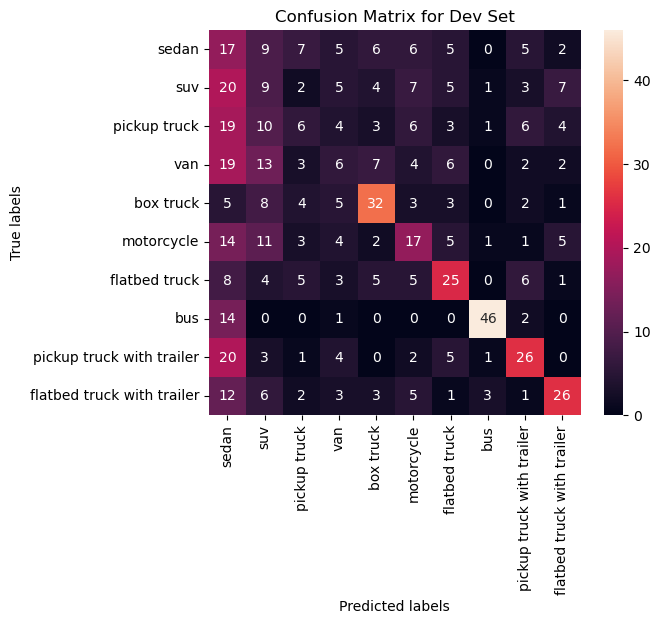

In [167]:
# OPTIONAL - Print dev set accuracy score and plot confusion matrix
print("Accuracy Score for Dev Set:", dev_ac)

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
sns.heatmap(dev_cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix for Dev Set')
ax.xaxis.set_ticklabels(labels,rotation=90)
ax.yaxis.set_ticklabels(labels,rotation=0)
plt.show()

In [171]:
# OPTIONAL - Print accuracy scores for each label:
print("Accuracy scores for each label in Dev Set:")
for i in range(10):
    print("Accuracy score for label {} ({}): {:.2f}%".format(i, labels[i], dev_cm[i][i]/dev_num_images[i]*100))


Accuracy scores for each label in Dev Set
Accuracy score for label 0 (sedan): 27.42%
Accuracy score for label 1 (suv): 14.29%
Accuracy score for label 2 (pickup truck): 9.68%
Accuracy score for label 3 (van): 9.68%
Accuracy score for label 4 (box truck): 50.79%
Accuracy score for label 5 (motorcycle): 26.98%
Accuracy score for label 6 (flatbed truck): 40.32%
Accuracy score for label 7 (bus): 73.02%
Accuracy score for label 8 (pickup truck with trailer): 41.94%
Accuracy score for label 9 (flatbed truck with trailer): 41.94%


Based on these results and tuning parameters, we decide to move forward and evaluate the test set.

In [174]:
# OPTIONAL - Classify on test set and generate confusion matrix and accuracy scores
# Predicting the test set results
y_test_pred = classifier.predict(X_test_scaled)

# Making the Confusion Matrix
# Confusion matrix whose i-th row and j-th column entry indicates 
# the number of samples with true label being i-th class and predicted label being j-th class.
# Rows = True, Columns = Predicted

test_cm = confusion_matrix(Y_test, y_test_pred)
test_ac = accuracy_score(Y_test, y_test_pred )

Accuracy Score for Test Set: 30.13%


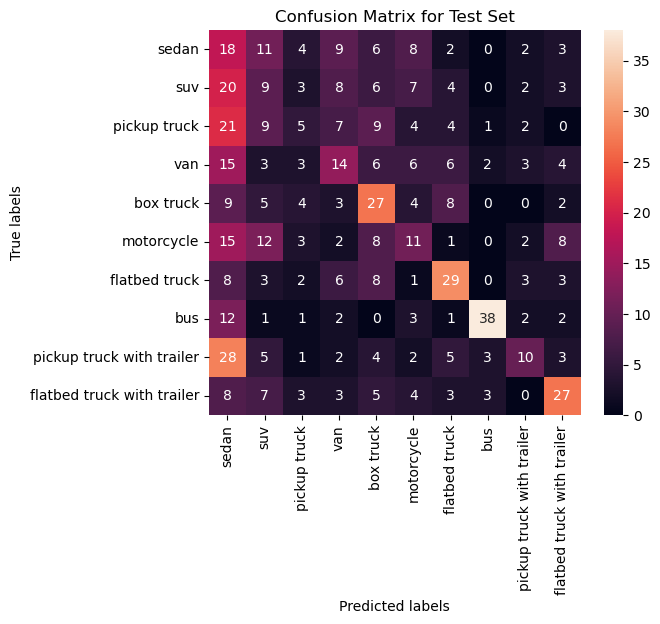

In [178]:
# OPTIONAL - Print test set accuracy score and plot confusion matrix
print("Accuracy Score for Test Set: {:.2f}%".format(100*test_ac))

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
sns.heatmap(test_cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix for Test Set')
ax.xaxis.set_ticklabels(labels,rotation=90)
ax.yaxis.set_ticklabels(labels,rotation=0)
plt.show()

In [179]:
# OPTIONAL - Print accuracy scores for each label:
print("Accuracy scores for each label in Test Set:")
for i in range(10):
    print("Accuracy score for label {} ({}): {:.2f}%".format(i, labels[i], test_cm[i][i]/test_num_images[i]*100))


Accuracy scores for each label in Test Set:
Accuracy score for label 0 (sedan): 28.57%
Accuracy score for label 1 (suv): 14.52%
Accuracy score for label 2 (pickup truck): 8.06%
Accuracy score for label 3 (van): 22.58%
Accuracy score for label 4 (box truck): 43.55%
Accuracy score for label 5 (motorcycle): 17.74%
Accuracy score for label 6 (flatbed truck): 46.03%
Accuracy score for label 7 (bus): 61.29%
Accuracy score for label 8 (pickup truck with trailer): 15.87%
Accuracy score for label 9 (flatbed truck with trailer): 42.86%


## 2.2. HOG and Pixel Feature Engineering (Shirley)

### 2.2.1. PCA Dimensionality Reduction and Tsne visualization (Shirley)

### 2.2.1. Classification on PCA reduced HOG Features (Tiffany & Shirley???)

# 3. Learning-based Feature Engineering and Classification

In line with more modern methods in computer vision, we first fit a basic convolutional neural network on EO images only, achieving an overall accuracy of **87 percent**. The CNN architectures automatically handle feature engineering through its convolutional layers, which attempt to pull out local features as a kernel convolves over the image. Finally, we try a full black-box approach to both image featurization and classification, using a ResNet-152 model to generate image embeddings and then using an automated machine learning process [AutoSKlearn](https://automl.github.io/auto-sklearn/master/index.html) library to perform automatic model search and hyperparameter tuning. This out-of-the box approach achieves **90 percent accuracy**, highlighting the power of transfer learning: using a large pre-trained model to generate the image embedding. Additionally, a process like AutoSKlearn's automated machine learning process removes the need for tedious model search and hyperparameter tuning.

Our code for the convolutional neural network can be found here: [cnn supplemental notebook](supplemental/mavoc_basic_cnn.ipynb).
Our code for the black box approach can be found here: [black box supplemental notebook](supplemental/learned_feature.ipynb).

# 4. Conclusion (Everyone) - WIP

*(Comparison of classification methods, discussion of possible reasons why the
classifier might work better for some categories than others, and explanation of the limitations of
the classifier)*

Overall accuracy of kNN: 30.13%
Accuracy per label of kNN: 
Accuracy score for label 0 (sedan): 28.57%
Accuracy score for label 1 (suv): 14.52%
Accuracy score for label 2 (pickup truck): 8.06%
Accuracy score for label 3 (van): 22.58%
Accuracy score for label 4 (box truck): 43.55%
Accuracy score for label 5 (motorcycle): 17.74%
Accuracy score for label 6 (flatbed truck): 46.03%
Accuracy score for label 7 (bus): 61.29%
Accuracy score for label 8 (pickup truck with trailer): 15.87%
Accuracy score for label 9 (flatbed truck with trailer): 42.86%

State of the art from [paper](https://arxiv.org/pdf/2205.01920.pdf) shows 31.86% accuracy when using combined SAR and EO imagery
